### STOCK PRICE PREDICTION

#### 1. IMPORT LIBRARIES

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D

#### 2. DATA PRE-PROCESSING, EDA

In [2]:
# Load Dataset
data_path = r"C:\Users\srira\Downloads\907 DL Lab Project\stock_data.csv"
df = pd.read_csv(data_path)

In [3]:
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df.head()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
Date,,,,,
2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [6]:
df.columns

Index(['Stock_1', 'Stock_2', 'Stock_3', 'Stock_4', 'Stock_5'], dtype='object')

<Figure size 1000x600 with 0 Axes>

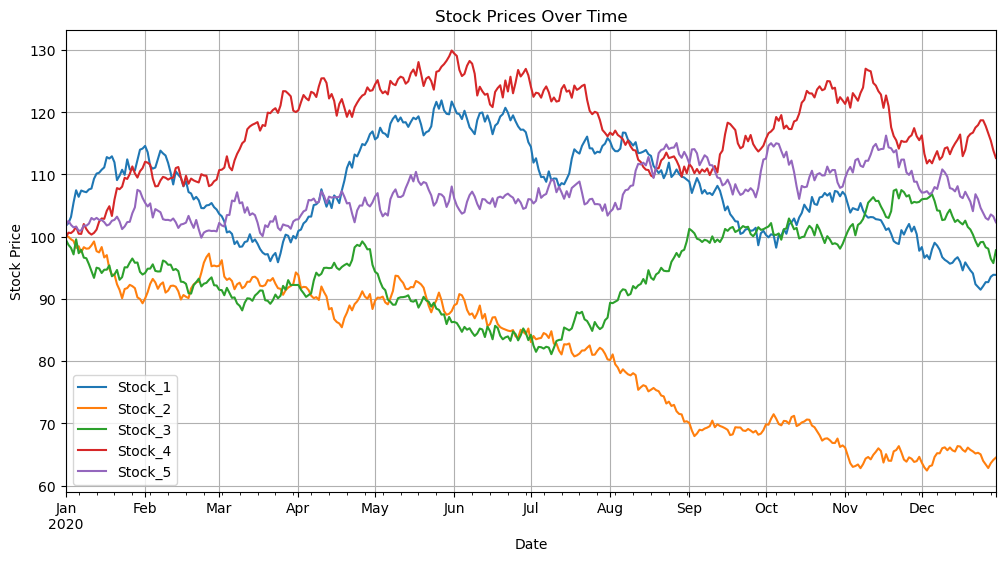

In [7]:
# EDA and Visualization
plt.figure(figsize=(10, 6))
df.plot(title="Stock Prices Over Time", figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

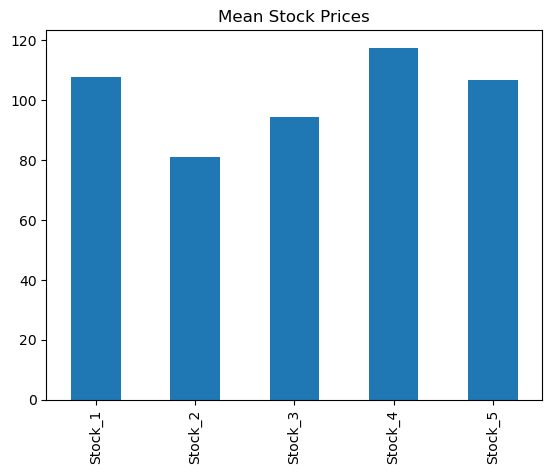

In [8]:
# Bar Plot (mean price of each stock)
df.mean().plot(kind='bar', title='Mean Stock Prices')
plt.show()

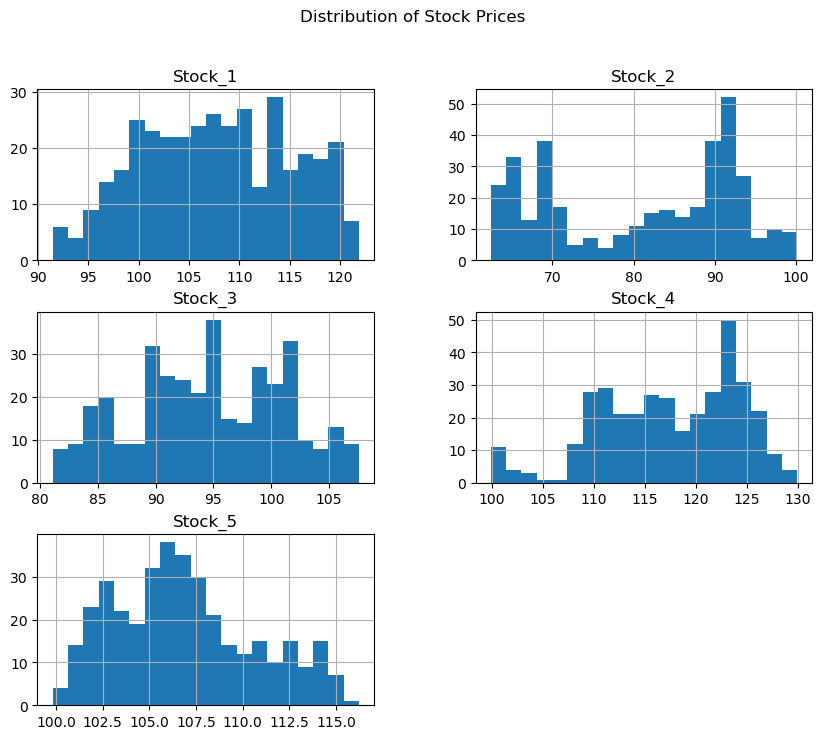

In [9]:
# Hist Plot
df.hist(figsize=(10, 8), bins=20)
plt.suptitle("Distribution of Stock Prices")
plt.show()

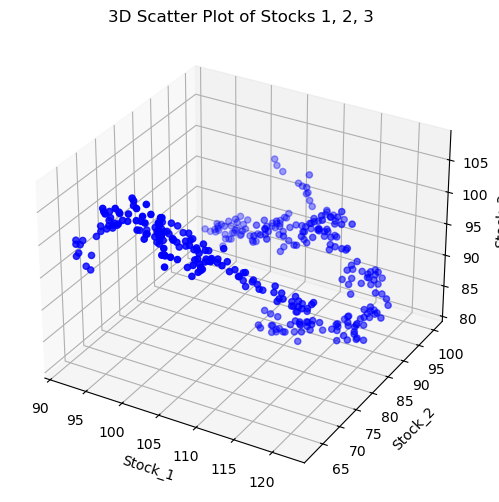

In [13]:
# 3D Scatter Plot (using first 3 stocks)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Stock_1'], df['Stock_2'], df['Stock_3'], c='blue', marker='o')
ax.set_xlabel('Stock_1')
ax.set_ylabel('Stock_2')
ax.set_zlabel('Stock_3')
ax.set_title('3D Scatter Plot of Stocks 1, 2, 3')
plt.show()

In [14]:
stock = 'Stock_1'  # You can change this to any stock
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[stock]])
# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)
window_size = 30
X, y = create_sequences(scaled_data, window_size)

In [16]:
# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### 4. MODEL BUILDING (BI-LSTM)

In [17]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

C:\Users\srira\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,737 (518.50 KB)

 Trainable params: 132,737 (518.50 KB)

 Non-trainable params: 0 (0.00 B)

#### 4. MODEL TRAINING

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - loss: 0.1779 - mae: 0.3536 - val_loss: 0.0199 - val_mae: 0.1289
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0266 - mae: 0.1329 - val_loss: 0.0104 - val_mae: 0.0888
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0216 - mae: 0.1209 - val_loss: 0.0223 - val_mae: 0.1358
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0165 - mae: 0.1079 - val_loss: 0.0096 - val_mae: 0.0859
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0140 - mae: 0.0982 - val_loss: 0.0123 - val_mae: 0.0995
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0131 - mae: 0.0967 - val_loss: 0.0074 - val_mae: 0.0749
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0110 - mae: 0.0865 - val_loss: 0.0075 - val_mae: 0.0759
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0099 - mae: 0.0819 - val_loss: 0.0050 - val_mae: 0.0603
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0084 - mae: 0.0725 

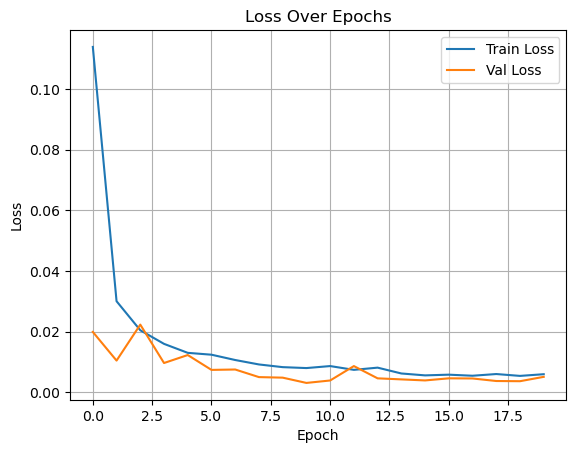

In [19]:
# Plot training accuracy and loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#### 5. MODEL EVALUATION

In [20]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step


In [21]:
# Convert to class labels for metrics
y_test_cls = (y_test_inv > np.mean(y_test_inv)).astype(int)
y_pred_cls = (y_pred_inv > np.mean(y_test_inv)).astype(int)

# Accuracy Metrics
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall:", recall_score(y_test_cls, y_pred_cls))
print("F1 Score:", f1_score(y_test_cls, y_pred_cls))
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.9104477611940298
Precision: 0.8461538461538461
Recall: 1.0
F1 Score: 0.9166666666666666

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        34
           1       0.85      1.00      0.92        33

    accuracy                           0.91        67
   macro avg       0.92      0.91      0.91        67
weighted avg       0.92      0.91      0.91        67



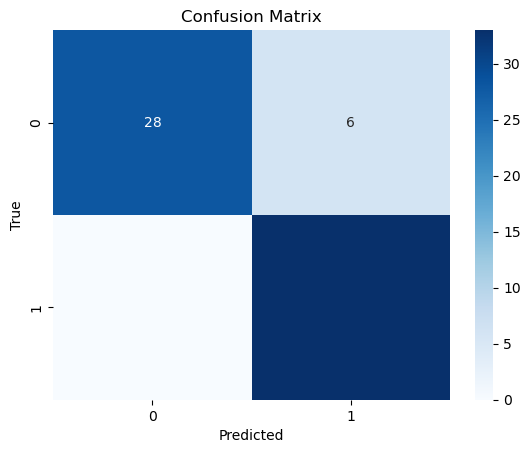

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

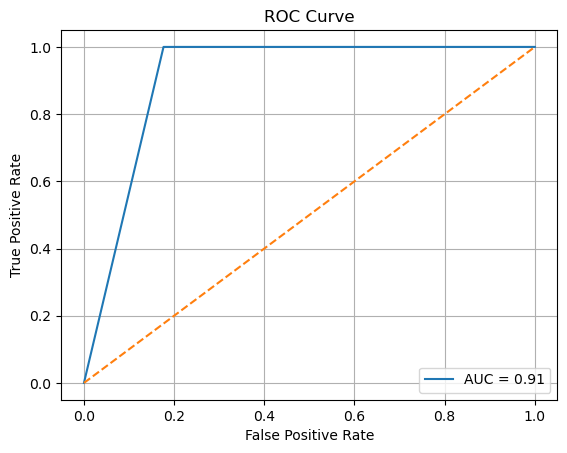

In [23]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_cls, y_pred_cls)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()